# Importing Libraries

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
!pip install scikit-plot
!pip install eli5

In [44]:
import datetime
import warnings
# linear algebra
import numpy as np
# data processing
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings('ignore')
# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from scikitplot.metrics import plot_confusion_matrix,plot_precision_recall_curve
from datetime import time
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()
import plotly.graph_objs as go
import eli5
from eli5.sklearn import PermutationImportance

Output hidden; open in https://colab.research.google.com to view.

In [0]:
import gc
# Enable automatic garbage collection.
gc.enable()
#For Repreduciton the 
seed = 127
np.random.seed(seed)

In [0]:
paribas_data = pd.read_csv('/content/drive/My Drive/Project with Enas Kh/Thesis/Codes and Dataset/AwE/Gender/2_Gender_PCA/GenderPCA_train.csv')

In [50]:
paribas_data.shape

(342, 23)

In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(
   paribas_data.drop(labels=[], axis=1),
    paribas_data['target'],
    test_size=0.2,
    random_state=41)

# Load & Explore Dataset

In [0]:
#load data
train_df = train_features
test_df = test_features

In [54]:
train_features.shape

(273, 23)

In [55]:
test_features.shape

(69, 23)

In [56]:
#Explore the train data
train_df.head()

,id,target,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,target.1
283,284,0,1.751269,-92.037621,75.727647,102.456727,49.809269,27.643398,-4.946531,9.079841,6.766523,-10.693413,2.116336,-8.463020,-16.420486,15.841792,-0.030066,-3.783405,3.231782,-1.794921,6.497444,-0.675679,0
274,275,1,1.611675,-89.701446,-135.336228,33.085042,-59.450892,10.564459,-36.129997,15.398349,0.929992,1.148168,7.161635,-6.496484,19.196545,-8.650620,4.847634,-12.907754,2.138850,2.453024,-3.277289,5.018448,1
36,37,1,5222.470515,-80.500572,-8.068066,-38.074502,36.552261,-26.260581,-37.034284,61.382809,1.299607,-3.469678,-13.556338,-1.588875,-13.003124,-35.401523,-18.328008,-1.911761,7.918506,5.713666,7.494659,-4.151842,1
118,119,0,-9283.241834,86.681385,89.527713,21.697547,17.351139,0.444739,-7.075409,5.604169,-0.339583,1.781531,1.157840,0.434502,0.936635,-2.546228,-0.735578,1.458908,-1.075816,0.614349,-0.340967,-0.464022,0
108,109,0,4797.030413,-56.011721,8.796427,1.475363,2.232655,1.412181,-0.787332,0.574220,-0.087534,-0.179494,0.038693,-0.254663,0.239534,0.309678,0.009162,0.047593,-0.018901,-0.210326,0.521034,-0.940790,0


In [57]:
#Explore the test data
test_df.head()

,id,target,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,target.1
327,328,1,-0.007345,-7.536697,-84.173989,89.134810,-10.698839,48.040829,-58.683932,-7.413617,-6.729727,-24.129245,11.613828,-3.686466,48.580459,22.475748,7.093008,-10.417120,3.194414,7.882826,-1.300591,3.685921,1
315,316,0,0.101677,-5.238567,-98.100387,56.824142,-14.087258,-31.009959,-18.535718,0.656177,-74.637683,-22.133026,27.630382,34.296271,-22.176172,1.897991,20.517391,-6.325235,1.128643,1.028835,-10.352045,2.022236,0
199,200,0,-0.599213,35.498465,135.504553,-1.537794,12.970078,17.109917,-11.929558,-11.423988,-1.192615,-0.058429,-2.127676,-2.262787,1.110678,-3.068530,2.033579,1.506352,-2.742050,0.951666,-1.946411,0.096134,0
230,231,0,3.243972,-169.807228,-92.037764,-81.561943,-63.376636,-26.129146,-16.590525,-47.539715,-12.820722,49.435052,37.125362,-40.896590,6.228522,10.952518,-29.863391,-23.374945,-12.372291,-14.160126,0.790476,3.331869,0
214,215,0,-1.028998,56.784703,94.300100,-30.648690,-7.872386,18.991097,-10.121130,-7.687442,2.372939,1.306979,-1.958556,-1.992209,1.084409,-1.544952,2.203734,1.078883,-1.179077,1.363925,-1.700349,0.812730,0


In [58]:
#Size Dataset
train_df.shape , test_df.shape

((273, 23), (69, 23))

In [59]:
#count of target in train data
train_df.groupby('target').count()['id']

target
0    128
1    145
Name: id, dtype: int64

In [60]:
#data type for train data
pd.DataFrame(train_df.dtypes).transpose()

,id,target,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,target.1
0,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64


In [61]:
#data type for test data
pd.DataFrame(test_df.dtypes).transpose()

,id,target,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,target.1
0,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64


# Check for Missing data & data type

In [62]:
#Finding the missing values in train and test data
train_missing=train_df.isnull().sum().sum()
test_missing=test_df.isnull().sum().sum()
print('Missing values in train data :',train_missing)
print('Missing values in test data :',test_missing)

Missing values in train data : 0
Missing values in test data : 0


# Describe Data

In [63]:
# describe train
train_df.describe()

,id,target,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,target.1
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,170.805861,0.531136,69.718949,5.200161,0.062653,0.322518,0.792568,1.328634,-0.155895,0.385127,0.651156,-0.353126,-0.526479,-0.053845,0.331563,-0.265908,-0.078831,0.302633,-0.179263,-0.034156,0.173246,-0.065735,0.531136
std,98.920176,0.499946,5175.070004,133.389707,72.550476,43.667351,34.265473,29.054107,28.726462,21.031982,20.320757,15.557614,15.043812,13.811272,12.214544,11.940926,9.410400,9.263444,8.411901,7.683341,7.937800,7.623703,0.499946
min,1.000000,0.000000,-9283.284399,-301.314954,-164.183581,-101.361578,-82.742632,-82.643281,-63.891349,-71.341901,-83.211359,-66.236277,-44.146800,-42.118851,-30.988269,-35.401523,-44.236756,-37.284934,-31.284004,-32.329860,-20.131538,-27.460966,0.000000
25%,86.000000,0.000000,-1.245435,-89.051073,-33.997963,-31.621748,-20.322345,-8.711921,-17.518372,-8.323780,-1.303536,-6.033573,-5.488731,-3.948401,-3.100205,-2.380287,-2.626801,-1.928751,-1.504753,-1.263565,-1.845103,-1.407769,0.000000
50%,168.000000,1.000000,1.751269,-5.740670,3.038469,-0.138441,0.047668,0.555713,-2.661803,0.883443,0.072175,0.164911,-0.345623,-0.798159,0.291786,-0.285299,-0.097050,0.227202,-0.006527,0.159334,-0.039659,-0.253204,1.000000
75%,260.000000,1.000000,4158.285248,78.194010,52.532420,23.822605,16.081394,15.766121,6.886461,6.917080,6.515660,3.457371,2.043316,0.636787,1.055200,2.071204,3.128417,1.538587,2.138850,1.591839,1.113897,1.238471,1.000000
max,341.000000,1.000000,13106.855920,393.712692,174.405540,130.106954,110.207315,98.249693,81.156725,76.052034,111.569162,90.735302,71.376223,94.794354,55.222032,34.402129,54.432520,56.659498,34.630749,46.779761,45.252496,37.257223,1.000000


In [64]:
# describe test
test_df.describe()

,id,target,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,target.1
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,174.246377,0.463768,-275.844536,-20.574551,-0.247887,-1.276048,-3.135813,-5.256768,0.616802,-1.523763,-2.576312,1.397151,2.083024,0.213039,-1.311834,1.052069,0.311898,-1.197374,0.709257,0.135139,-0.685453,0.260081,0.463768
std,99.352226,0.502339,5041.026329,134.796674,75.649724,42.174243,36.369530,33.707165,30.811322,23.923328,22.169012,18.626082,15.752388,17.370865,14.551020,12.567070,16.422578,12.202423,9.802313,9.862195,8.301182,6.360424,0.502339
min,10.000000,0.000000,-9283.201828,-338.780796,-162.330998,-96.335570,-74.185357,-78.194320,-58.683932,-69.826050,-97.243351,-41.137395,-47.950365,-40.999793,-25.335020,-33.705566,-38.151027,-37.884496,-24.970687,-27.610071,-18.844696,-25.124678,0.000000
25%,87.000000,0.000000,-0.918407,-99.699512,-60.642447,-31.922945,-22.830232,-23.737436,-22.292099,-11.423988,-6.729727,-5.660122,-2.341915,-2.908505,-11.952193,-1.306639,-4.145747,-4.995120,-1.179077,-2.468281,-1.946411,-0.804701,0.000000
50%,193.000000,0.000000,1.610322,-8.898123,4.573350,0.900536,-5.327175,-3.095473,-2.939607,-0.725299,0.065483,-0.311455,-0.107091,-0.340464,-0.095529,0.454348,-0.285308,0.487722,0.238930,0.025270,-0.052741,0.099910,0.000000
75%,240.000000,1.000000,2484.122657,78.178708,56.169749,29.691738,12.970078,15.373397,20.573388,6.128817,5.157224,3.343999,6.372938,1.752756,0.766333,2.101033,2.563302,1.933171,3.194414,1.455044,1.197323,2.230799,1.000000
max,342.000000,1.000000,9710.787934,343.144125,175.672350,89.134810,108.421328,93.987953,74.090208,52.700880,54.444935,70.922448,58.807110,79.622278,52.667621,38.000495,82.362982,37.184476,38.666967,28.099393,35.909324,15.195497,1.000000


# Distribution of target value

There are 53.11355311355312% target values with 1
There are 46.88644688644688% target values with 0


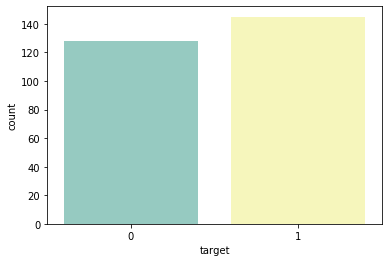

In [65]:
#The distribution of target value in train dataset
sns.countplot(train_df['target'], palette='Set3')

#The data is unbalanced with respect with target value
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0])),
print("There are {}% target values with 0".format(100 * train_df["target"].value_counts()[0]/train_df.shape[0]))

# scaling dataset

In [66]:
data= train_df 
y = data['target']
X = data.drop(['target', 'id'], axis=1)

#scaling dataset
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_scaled = sc.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,target.1
0,-0.013158,-0.730314,1.044844,2.343210,1.433125,0.907379,-0.167074,0.414164,0.301495,-0.665865,0.175997,-0.609981,-1.374003,1.351426,0.005192,-0.441903,0.406247,-0.229587,0.798182,-0.080153,-1.064337
1,-0.013185,-0.712768,-1.869699,0.751653,-1.761368,0.318467,-1.254598,0.715139,0.013747,0.096676,0.511987,-0.467334,1.547305,-0.703472,0.524474,-1.428696,0.276081,0.324305,-0.435495,0.668116,0.939552
2,0.997516,-0.643664,-0.112276,-0.880922,1.045524,-0.951324,-1.286135,2.905561,0.031969,-0.200691,-0.867718,-0.111347,-1.093711,-2.947857,-1.942818,-0.239486,0.964424,0.749463,0.924042,-0.536958,0.939552
3,-1.810630,0.611973,1.235407,0.490396,0.484131,-0.030478,-0.241318,0.248604,-0.048845,0.137462,0.112167,0.035424,0.049628,-0.191318,-0.069918,0.125051,-0.106777,0.084559,-0.064899,-0.052339,-1.064337
4,0.915155,-0.459738,0.120603,0.026449,0.042105,0.002881,-0.022021,0.009007,-0.036418,0.011181,0.037637,-0.014567,-0.007548,0.048291,0.009368,-0.027582,0.019099,-0.022971,0.043895,-0.114992,-1.064337


In [67]:
#splitting dataset into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=101, stratify=y)
X_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,target.1
156,-0.013098,-0.868775,-1.153876,1.100859,0.730254,0.210953,2.277612,0.361253,-0.322385,0.035023,0.609858,-0.141455,-1.643243,-2.122592,-2.353318,1.646026,-2.954148,2.607663,-0.003768,-1.173985,0.939552
78,-0.617080,-0.092121,-0.019473,-0.024230,-0.108689,-0.154899,0.077311,-0.044512,-0.062429,-0.021085,0.051599,0.034389,-0.007478,0.060049,-0.114550,0.037648,0.088723,-0.034139,0.083904,-0.098406,0.939552
261,0.963309,0.046183,0.037366,-0.010576,0.118016,0.100281,-0.089318,0.054084,-0.028781,0.092204,-0.015080,-0.063918,-0.002957,-0.000342,0.146603,-0.048782,-0.040926,0.043632,-0.034910,-0.004341,0.939552
90,1.817794,-0.188002,0.120553,0.019491,0.197849,0.182938,-0.141032,0.081719,-0.014601,0.105434,-0.020094,-0.088875,-0.003262,-0.004190,0.207224,-0.083850,-0.075366,0.046198,-0.051096,-0.021174,-1.064337
40,-0.013492,-0.138272,-1.456149,-0.978087,-0.463682,2.459981,0.086810,1.244984,1.240674,0.534873,0.820896,-0.525849,-0.084671,-1.438773,0.239809,0.638275,-0.104841,-0.047719,-0.958821,0.070274,0.939552


In [68]:
#size after scale and split
X_train.shape, X_test.shape

((191, 21), (82, 21))

In [0]:
#The scatter plot for train and test set for few of the features
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

In [0]:
#The scatter plot for 16 features
#features = ['var_0','var_1','var_2','var_5','var_6','var_9','var_11','var_12','var_13','var_16','var_18',
 #           'var_21','var_22','var_23','var_24','var_26']
#plot_feature_scatter(train_df[::20],test_df[::20], features)

In [0]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

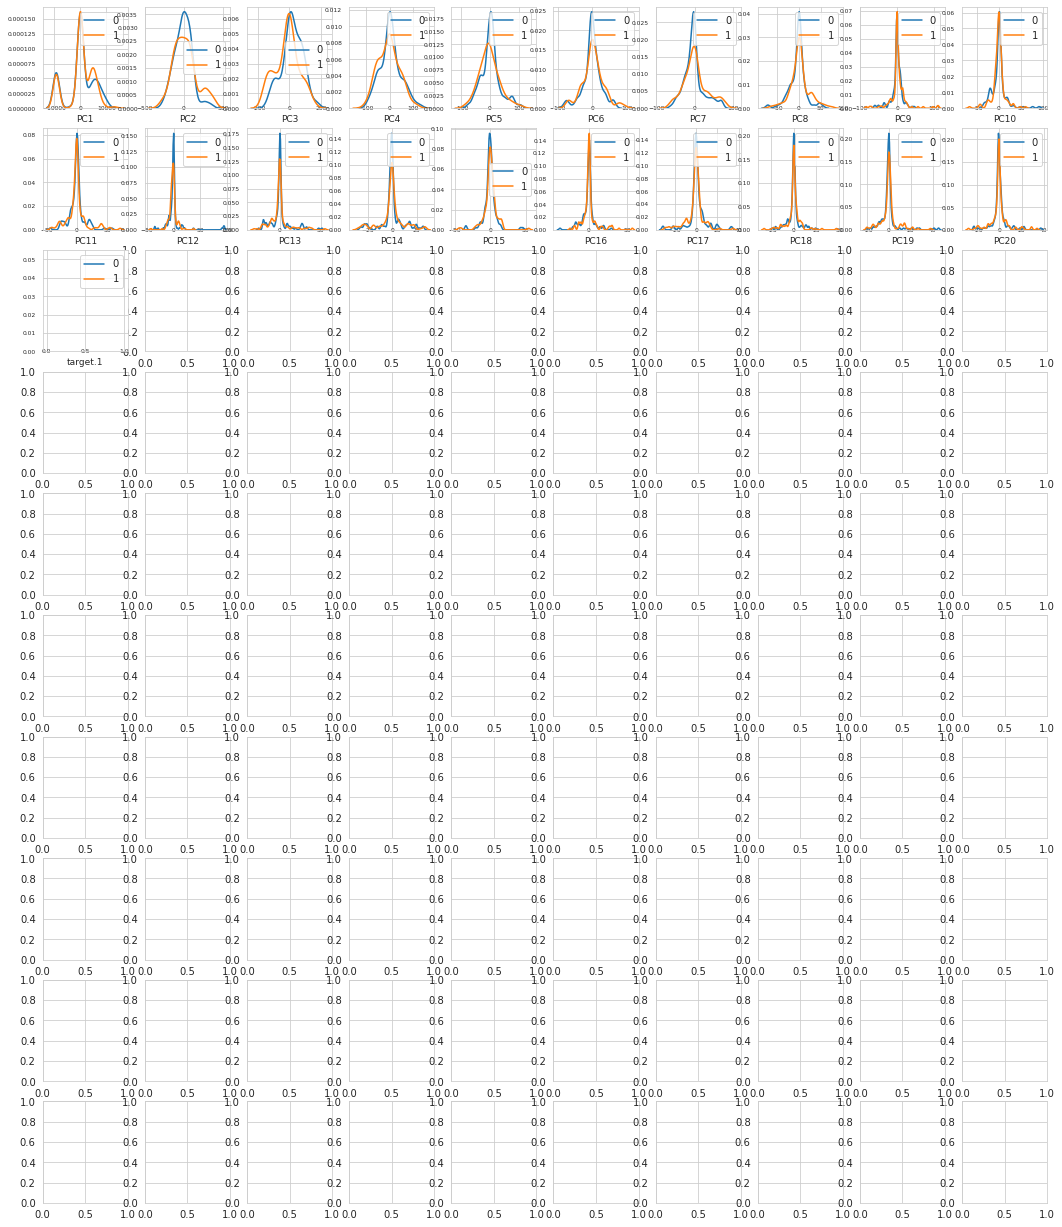

In [71]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

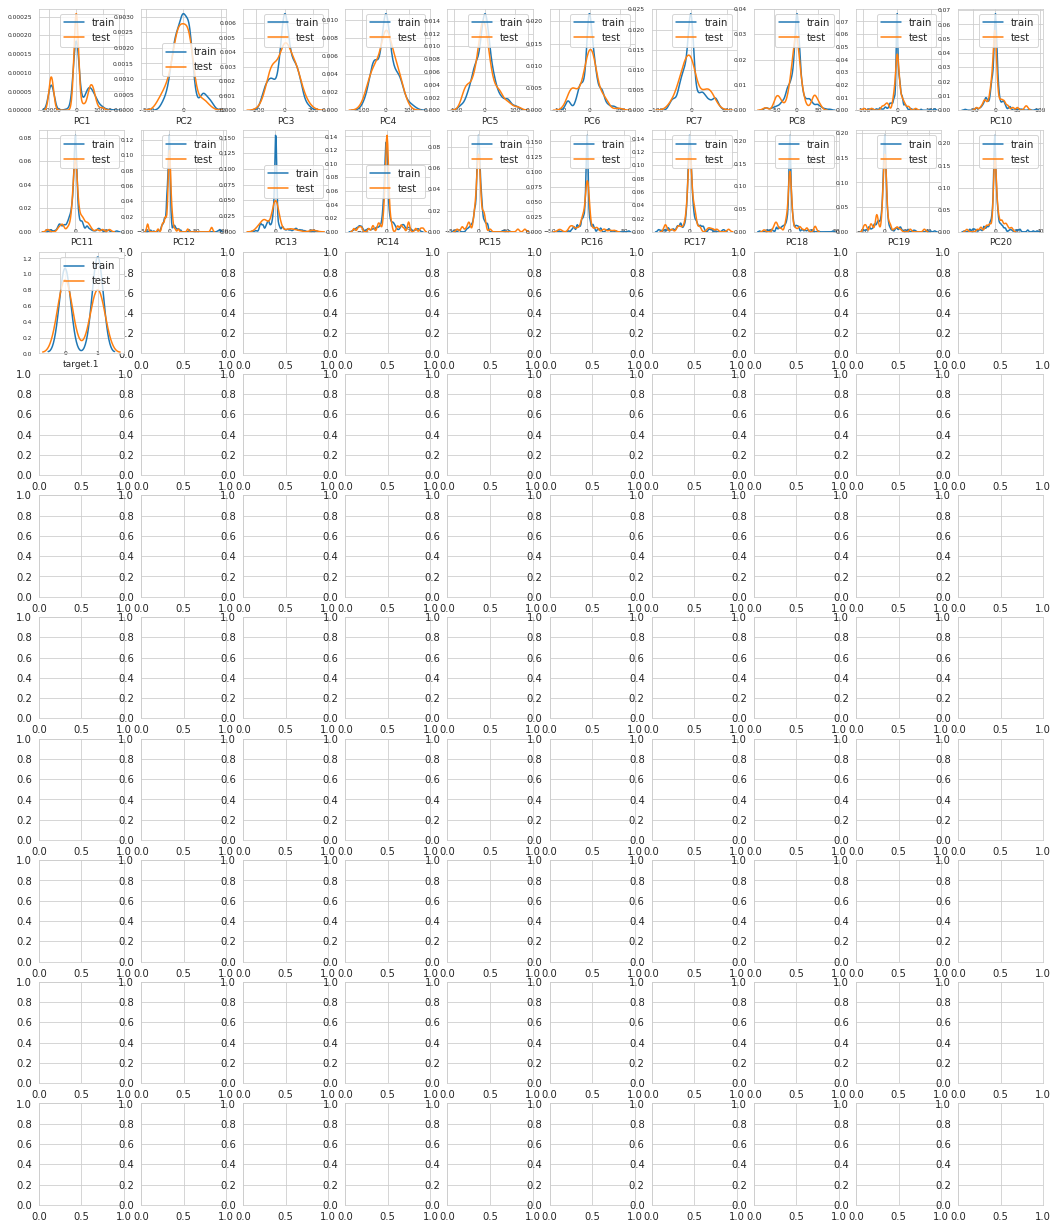

In [72]:
features = train_df.columns.values[2:102]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

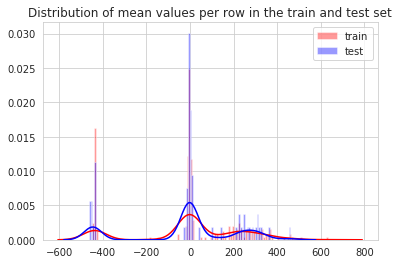

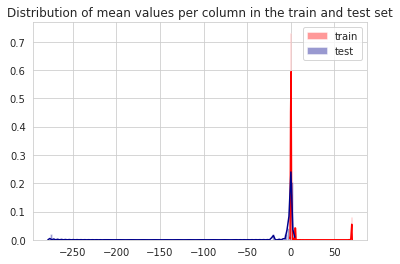

In [73]:
#The distribution of the mean values per row in the train & test set
#plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features].mean(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

#The distribution of the mean values per column in the train & test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0),color="red",kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

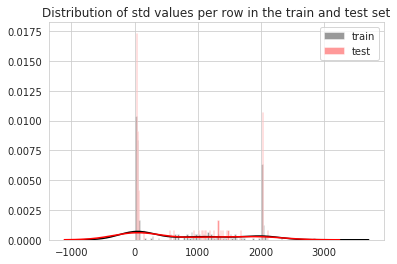

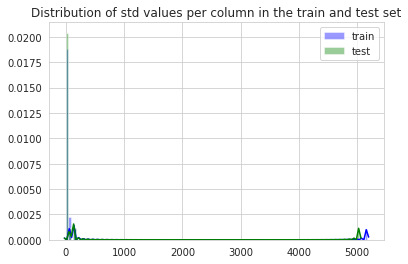

In [74]:
# The distribution of std values per row in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_df[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

# The distribution of std values per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

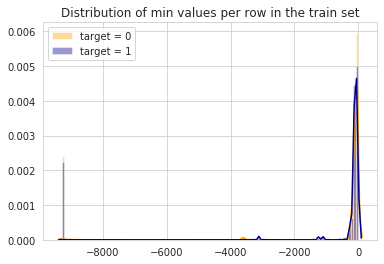

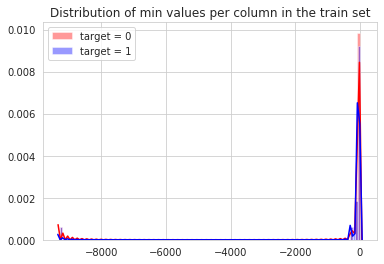

In [75]:
# The distribution of min values per row in the train and test set
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
#plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# The distribution of min values per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

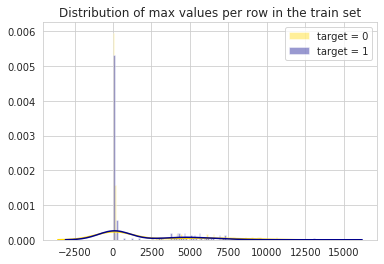

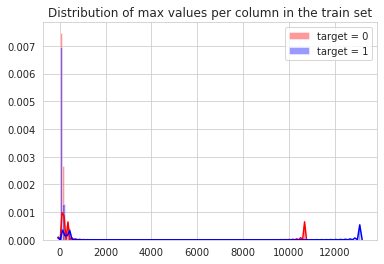

In [77]:
# The distribution of max values per row in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# The distribution of max values per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

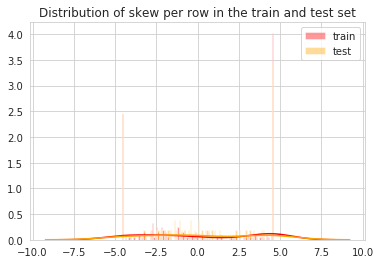

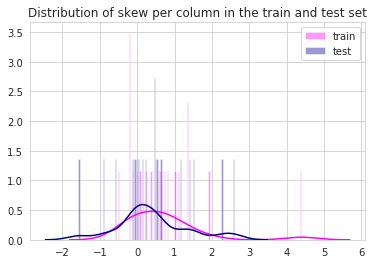

In [78]:
#Distribution of skew per row in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train_df[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

#Distribution of skew per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train_df[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

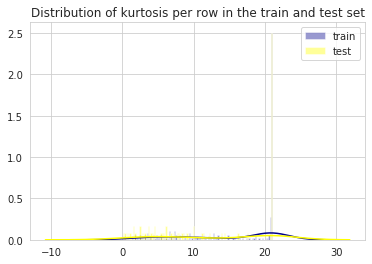

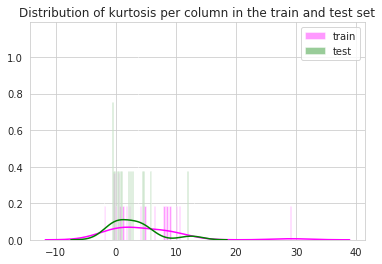

In [79]:
#Distribution of kurtosis per row in the train and test 
#plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=1),color="darkblue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

#Distribution of kurtosis per column in the train and test 
#plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()


# Correlation between the attributes

In [80]:
#Correlation between the attributes for train data
#Correlations in train attributes
train_attributes=train_df.columns.values[2:202]
train_correlations=train_df[train_attributes].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
train_correlations=train_correlations[train_correlations['level_0']!=train_correlations['level_1']]
train_correlations.head(10)

#print(train_correlations.head(10))
#print(train_correlations.tail(10))

,level_0,level_1,0
0,PC18,PC1,0.000073
1,PC1,PC18,0.000073
2,target.1,PC1,0.000477
3,PC1,target.1,0.000477
4,PC19,PC9,0.000945
5,PC9,PC19,0.000945
6,PC19,PC3,0.000957
7,PC3,PC19,0.000957
8,PC13,PC2,0.001403
9,PC2,PC13,0.001403


In [81]:
train_correlations.tail(10)

,level_0,level_1,0
410,PC15,PC2,0.144210
411,PC2,PC15,0.144210
412,PC18,PC16,0.145821
413,PC16,PC18,0.145821
414,PC15,PC10,0.165086
415,PC10,PC15,0.165086
416,PC15,PC16,0.190593
417,PC16,PC15,0.190593
418,PC3,target.1,0.224334
419,target.1,PC3,0.224334


In [82]:
#Correlation between the attributes for test data
#Correlations in test attributes
test_attributes=test_df.columns.values[1:201]
test_correlations=test_df[test_attributes].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
test_correlations=test_correlations[test_correlations['level_0']!=test_correlations['level_1']]
test_correlations.head(10)

#print(test_correlations.head(10))
#print(test_correlations.tail(10))

,level_0,level_1,0
0,PC6,PC14,0.000189
1,PC14,PC6,0.000189
2,PC18,PC1,0.000719
3,PC1,PC18,0.000719
4,PC4,PC6,0.001815
5,PC6,PC4,0.001815
6,PC8,PC16,0.002357
7,PC16,PC8,0.002357
8,PC3,PC19,0.003856
9,PC19,PC3,0.003856


In [83]:
test_correlations.tail(10)

,level_0,level_1,0
452,PC11,PC12,0.335314
453,PC12,PC11,0.335314
454,PC9,PC16,0.337297
455,PC16,PC9,0.337297
456,PC18,PC16,0.346680
457,PC16,PC18,0.346680
458,PC11,PC16,0.362542
459,PC16,PC11,0.362542
460,target.1,target,1.000000
463,target,target.1,1.000000


# Correlation plot for train and test data

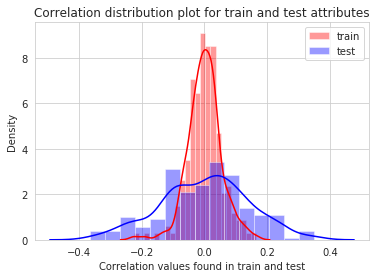

In [84]:
#Correlation plot for train and test data
# correlation between the train and test attributes is very very small
#it means that features are independent each other.
#Correlations in train data
train_correlations=train_df[train_attributes].corr()
train_correlations=train_correlations.values.flatten()
train_correlations=train_correlations[train_correlations!=1]
#Correlations in test data
test_correlations=test_df[test_attributes].corr()
test_correlations=test_correlations.values.flatten()
test_correlations=test_correlations[test_correlations!=1]

#plt.figure(figsize=(20,5))
#Distribution plot for correlations in train data
sns.distplot(train_correlations, color="Red", label="train")
#Distribution plot for correlations in test data
sns.distplot(test_correlations, color="Blue", label="test")
plt.xlabel("Correlation values found in train and test")
plt.ylabel("Density")
plt.title("Correlation distribution plot for train and test attributes")
plt.legend()

In [0]:
#Feature engineering
#Permutation variable importance measure in a random forest for classification
X=train_df.drop(columns=['id','target'],axis=1)
test=test_df.drop(columns=['id'],axis=1)
Y=train_df['target']

In [86]:
#build simple model to find features which are more important
#Split the training data
x_train,x_test,y_train, y_test = train_test_split(X, Y, random_state=42)

print('Shape of X_train :',x_train.shape)
print('Shape of X_test :',x_test.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of y_test:',y_test.shape)

Shape of X_train : (204, 21)
Shape of X_test : (69, 21)
Shape of y_train : (204,)
Shape of y_test: (69,)


In [87]:
#Split the train data using StratefiedKFold cross validator
#Training data
X=train_df.drop(['id','target'],axis=1)
Y=train_df['target']
#StratifiedKFold cross validator
cv=StratifiedKFold(n_splits=5,random_state=42,shuffle=True) #SPLITS=5
for train_index,test_index in cv.split(X,Y):
    x_train, x_test=X.iloc[train_index], X.iloc[test_index]
    y_train, y_test=Y.iloc[train_index], Y.iloc[test_index]

print('Shape of X_train :',x_train.shape)
print('Shape of X_valid :',x_test.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of y_valid :',y_test.shape)

Shape of X_train : (219, 21)
Shape of X_valid : (54, 21)
Shape of y_train : (219,)
Shape of y_valid : (54,)


In [0]:
# Importing Classifier Modules
import datetime, time, json
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
# Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# XGB Classifier

In [90]:
 #XGB
import datetime, time, json

print("Starting training at", datetime.datetime.now())
t0 = time.time()

model = XGBClassifier()
model.fit(x_train, y_train)
y_pred_xgb = model.predict(x_test)
acc_xgb = round (metrics.accuracy_score(y_test, y_pred_xgb) *100, 2)
Precision_xgb= round (metrics.precision_score(y_test, y_pred_xgb) *100, 2)
Recall_xgb = round (metrics.recall_score(y_test, y_pred_xgb) *100, 2)
F1_xgb = round (metrics.f1_score(y_test, y_pred_xgb) *100, 2)
ROC_xgb= round (metrics.roc_auc_score(y_test, y_pred_xgb)* 100, 2)  

print("Accuracy for XGBClassifier is: {}".format(acc_xgb))
print("precision_score for XGBClassifier is: {}".format(Precision_xgb))
print("Recall_score for XGBClassifier is: {}".format(Recall_xgb))
print("F1_score for XGBClassifier is: {}".format(F1_xgb))
print("ROC for XGBClassifier is: {}".format(ROC_xgb))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 15:43:51.112560
Accuracy for XGBClassifier is: 100.0
precision_score for XGBClassifier is: 100.0
Recall_score for XGBClassifier is: 100.0
F1_score for XGBClassifier is: 100.0
ROC for XGBClassifier is: 100.0
Training ended at 2020-03-16 15:43:51.232516
Minutes elapsed: 0.001984


# MLPClassifier  

In [91]:
import datetime, time, json

print("Starting training at", datetime.datetime.now())
t0 = time.time()

from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier()  
mlp.fit(x_train, y_train) 
y_pred_mlp = mlp.predict(x_test)  


acc_mlp = round (metrics.accuracy_score(y_test, y_pred_mlp) *100, 2)
Precision_mlp= round (metrics.precision_score(y_test, y_pred_mlp) *100, 2)
Recall_mlp = round (metrics.recall_score(y_test, y_pred_mlp) *100, 2)
F1_mlp = round (metrics.f1_score(y_test, y_pred_mlp) *100, 2)
ROC_mlp= round (metrics.roc_auc_score(y_test, y_pred_mlp)* 100, 2)  

print("Accuracy for MLP is: {}".format(acc_mlp))
print("precision_score for MLP is: {}".format(Precision_mlp))
print("Recall_score for MLP is: {}".format(Recall_mlp))
print("F1_score for MLP is: {}".format(F1_mlp))
print("ROC for MLP is: {}".format(ROC_mlp))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 15:43:57.668372
Accuracy for MLP is: 51.85
precision_score for MLP is: 56.0
Recall_score for MLP is: 48.28
F1_score for MLP is: 51.85
ROC for MLP is: 52.14
Training ended at 2020-03-16 15:43:57.815124
Minutes elapsed: 0.002430


# Linear SVM

In [92]:
# linear SVM
print("Starting training at", datetime.datetime.now())
t0 = time.time()

linear_svc = LinearSVC(dual=False)
scores = cross_val_score(linear_svc, x_train, y_train, cv=3, scoring = "accuracy")
linear_svc.fit(x_train, y_train)
Y_pred = linear_svc.predict(x_test)
precision_linear_svc = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_linear_svc = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_linear_svc = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_linear_svc = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_linear_svc = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print('linear SVM : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 15:44:04.831889
linear SVM : 
Precision: 100.0
Recall: 100.0
Accuracy: 100.0
f1 score: 100.0
ROC: 100.0
Training ended at 2020-03-16 15:44:04.975435
Minutes elapsed: 0.002378


### Naïve Bayes

In [93]:
# NB
print("Starting training at", datetime.datetime.now())
t0 = time.time()

gaussian = GaussianNB()
scores = cross_val_score(gaussian, x_train, y_train, cv=3, scoring="accuracy")
gaussian.fit(x_train, y_train)
Y_pred = gaussian.predict(x_test)
precision_gaussian = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_gaussian = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_gaussian = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_gaussian = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_gaussian= round(roc_auc_score(y_test, Y_pred) * 100, 2)
print('NB : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 15:44:09.342677
NB : 
Precision: 100.0
Recall: 100.0
Accuracy: 100.0
f1 score: 100.0
ROC: 100.0
Training ended at 2020-03-16 15:44:09.371700
Minutes elapsed: 0.000470


# Logistic Regression

In [94]:
# Logistic Regression

print("Starting training at", datetime.datetime.now())
t0 = time.time()

logreg = LogisticRegression(solver='lbfgs')
scores = cross_val_score(logreg, x_train, y_train, cv=3, scoring="accuracy")
logreg.fit(x_train, y_train)
Y_pred = logreg.predict(x_test)
precision_logreg = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_logreg = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_logreg = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_logreg = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_logreg = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print('Logistic Regression : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 15:44:14.308747
Logistic Regression : 
Precision: 64.1
Recall: 86.21
Accuracy: 66.67
f1 score: 73.53
ROC: 65.1
Training ended at 2020-03-16 15:44:14.448315
Minutes elapsed: 0.002299


# Decision Tree 

In [95]:
# Decision Tree Gini

print("Starting training at", datetime.datetime.now())
t0 = time.time()

decision_tree = DecisionTreeClassifier()
scores = cross_val_score(decision_tree, x_train, y_train, cv=3)
decision_tree.fit(x_train, y_train)
Y_pred = decision_tree.predict(x_test)
precision_tree_gini = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_tree_gini = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_tree_gini = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_tree_gini = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_tree_gini = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print('Desision tree : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 15:44:20.439891
Desision tree : 
Precision: 100.0
Recall: 100.0
Accuracy: 100.0
f1 score: 100.0
ROC: 100.0
Training ended at 2020-03-16 15:44:20.475976
Minutes elapsed: 0.000580


# Random Forest

In [96]:
#RandomForest
print("Starting training at", datetime.datetime.now())
t0 = time.time()

random_forest = RandomForestClassifier()
scores = cross_val_score(random_forest, x_train, y_train, cv=3)
random_forest.fit(x_train, y_train)
Y_pred = random_forest.predict(x_test)
precision_random_forest = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_random_forest = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_random_forest = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_random_forest = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_random_forest = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("random forest : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 15:44:25.798510
random forest : 
Precision: 100.0
Recall: 100.0
Accuracy: 100.0
f1 score: 100.0
ROC: 100.0
Training ended at 2020-03-16 15:44:26.414964
Minutes elapsed: 0.010255


# Gradient Boosting

In [97]:
#GradientBoosting
import datetime, time, json
print("Starting training at", datetime.datetime.now())
t0 = time.time()

gbrt = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, max_depth=5, subsample=0.5)
scores = cross_val_score(gbrt, x_train, y_train, cv=3)
gbrt.fit(x_train, y_train)
Y_pred = gbrt.predict(x_test)
precision_gbrt = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_gbrt = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_gbrt = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_gbrt = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_gbrt = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("Gradient Boosting Classifier : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 15:44:29.034082
Gradient Boosting Classifier : 
Precision: 100.0
Recall: 100.0
Accuracy: 100.0
f1 score: 100.0
ROC: 100.0
Training ended at 2020-03-16 15:44:29.677536
Minutes elapsed: 0.010711


#  Bagging Classifier with NB

In [98]:
# BaggingClassifier wiht NB
import datetime, time, json
print("Starting training at", datetime.datetime.now())
t0 = time.time()

bag_nb = BaggingClassifier(GaussianNB(), n_estimators=100, n_jobs=1, bootstrap=True, random_state=1)
scores = cross_val_score(bag_nb, x_train, y_train, cv=3)
bag_nb.fit(x_train, y_train)
Y_pred = bag_nb.predict(x_test)
precision_bag_nb = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_bag_nb = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_bag_nb = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_bag_nb = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_bag_nb = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)

print("BaggingClassifier with nb : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 15:44:32.560819
BaggingClassifier with nb : 
Precision: 100.0
Recall: 100.0
Accuracy: 100.0
f1 score: 100.0
ROC: 100.0
Training ended at 2020-03-16 15:44:33.150068
Minutes elapsed: 0.009807


# AdaBoost

In [99]:
#AdaBoost
print("Starting training at", datetime.datetime.now())
t0 = time.time()

ada = AdaBoostClassifier(algorithm="SAMME.R", n_estimators=300, learning_rate=0.2)
scores = cross_val_score(ada, x_train, y_train, cv=3)
ada.fit(x_train, y_train)
Y_pred = ada.predict(x_test)
precision_ada = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_ada = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_ada = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_ada = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_ada = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("Ada Boosting : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 15:44:36.801247
Ada Boosting : 
Precision: 100.0
Recall: 100.0
Accuracy: 100.0
f1 score: 100.0
ROC: 100.0
Training ended at 2020-03-16 15:44:36.841018
Minutes elapsed: 0.000653


# # Voting classifier

In [100]:
# Voting classifier
print("Starting training at", datetime.datetime.now())
t0 = time.time()
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('lsvm', linear_svc), ('Logistic_Regression', logreg), ('rf', random_forest), ('bd', bag_nb), ('NB', gaussian)],
                              voting='hard')
scores = cross_val_score(voting_clf, x_train, y_train, cv=3)
voting_clf.fit(x_train, y_train)
Y_pred = voting_clf.predict(x_test)
precision_voting = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_voting = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_voting = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_voting = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_voting = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("votting : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-16 15:44:40.012175
votting : 
Precision: 100.0
Recall: 100.0
Accuracy: 100.0
f1 score: 100.0
ROC: 100.0
Training ended at 2020-03-16 15:44:41.370462
Minutes elapsed: 0.022624


In [101]:
comparison = pd.DataFrame({
    'Model': ['XGB','MLP','SVM', 'NB', 'LR', 'DT ','RF',
              'GD', 'Bagging with NB', 'Ada Boosting', 'Voting'],
    'Precision': [Precision_xgb,Precision_mlp,precision_linear_svc, precision_gaussian, precision_logreg,
                  precision_tree_gini, precision_random_forest, precision_gbrt,
                  precision_bag_nb, precision_ada, precision_voting ],
    'Recall': [Recall_xgb, Recall_mlp, recall_linear_svc, recall_gaussian, recall_logreg,
                  recall_tree_gini, recall_random_forest, recall_gbrt,
                  recall_bag_nb, recall_ada, recall_voting],
    'F1_score': [F1_xgb, F1_mlp,f1score_linear_svc, f1score_gaussian, f1score_logreg,
                  f1score_tree_gini,f1score_random_forest, f1score_gbrt,
                  f1score_bag_nb, f1score_ada, f1score_voting],
        'ROC': [ROC_xgb,ROC_mlp, ROC_linear_svc, ROC_gaussian, ROC_logreg,
                  ROC_tree_gini, ROC_random_forest, ROC_gbrt,
                  ROC_bag_nb, ROC_ada, ROC_voting],
    'Accuracy': [acc_xgb,acc_mlp, accuracy_linear_svc, accuracy_gaussian, accuracy_logreg,
                  accuracy_tree_gini, accuracy_random_forest, accuracy_gbrt,
                   accuracy_bag_nb, accuracy_ada, accuracy_voting]
})
comparison

,Model,Precision,Recall,F1_score,ROC,Accuracy
0,XGB,100.0,100.00,100.00,100.00,100.00
1,MLP,56.0,48.28,51.85,52.14,51.85
2,SVM,100.0,100.00,100.00,100.00,100.00
3,NB,100.0,100.00,100.00,100.00,100.00
4,LR,64.1,86.21,73.53,65.10,66.67
5,DT,100.0,100.00,100.00,100.00,100.00
6,RF,100.0,100.00,100.00,100.00,100.00
7,GD,100.0,100.00,100.00,100.00,100.00
8,Bagging with NB,100.0,100.00,100.00,100.00,100.00
9,Ada Boosting,100.0,100.00,100.00,100.00,100.00


In [102]:
print(comparison)
comparison.plot(x='Model', kind=Model	Precision	Recall	F1_score	ROC	Accuracy
0	XGB	77.06	72.21	74.55	75.35	75.35
1	MLP	69.94	66.46	68.16	68.95	68.95
2	SVM	77.98	77.61	77.79	77.84	77.84
3	NB	79.98	80.02	80.00	80.00	80.00
4	LR	76.80	77.33	77.06	76.98	76.98
5	DT	59.59	59.99	59.79	59.65	59.65
6	RF	66.86	54.22	59.88	63.67	63.67
7	GD	80.57	77.90	79.22	79.56	79.56
8	Bagging with NB	79.95	79.97	79.96	79.96	79.96
9	Ada Boosting	79.59	75.86	77.68	78.20	78.20
10	Voting	79.62	78.45	79.03	79.19	79.19,'bar')
plt.show()

SyntaxError: ignored

In [104]:
#using random forests
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
predictionRFC = rfc.predict_proba(x_test)
predictionRFC

array([[0.2 , 0.8 ],
       [0.8 , 0.2 ],
       [0.05, 0.95],
       [0.07, 0.93],
       [0.85, 0.15],
       [0.07, 0.93],
       [0.88, 0.12],
       [0.07, 0.93],
       [0.91, 0.09],
       [0.9 , 0.1 ],
       [0.25, 0.75],
       [0.97, 0.03],
       [0.8 , 0.2 ],
       [0.09, 0.91],
       [0.18, 0.82],
       [0.77, 0.23],
       [0.83, 0.17],
       [0.11, 0.89],
       [0.13, 0.87],
       [0.15, 0.85],
       [0.16, 0.84],
       [0.88, 0.12],
       [0.13, 0.87],
       [0.11, 0.89],
       [0.13, 0.87],
       [0.12, 0.88],
       [0.84, 0.16],
       [0.79, 0.21],
       [0.15, 0.85],
       [0.08, 0.92],
       [0.08, 0.92],
       [0.87, 0.13],
       [0.85, 0.15],
       [0.95, 0.05],
       [0.94, 0.06],
       [0.85, 0.15],
       [0.11, 0.89],
       [0.1 , 0.9 ],
       [0.8 , 0.2 ],
       [0.82, 0.18],
       [0.19, 0.81],
       [0.14, 0.86],
       [0.94, 0.06],
       [0.82, 0.18],
       [0.08, 0.92],
       [0.15, 0.85],
       [0.04, 0.96],
       [0.08,

In [105]:
#probability that the mice gender might be male according to the body analysis (target class 1)
prob = [1 - item[0] for item in predictionRFC] 
prob[:5]

[0.8, 0.19999999999999996, 0.95, 0.9299999999999999, 0.15000000000000002]